### Importing necessary libraries

In [1]:
!pip3 install newsapi-python

In [358]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns  # For correlation heatmap
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import newsapi
from newsapi.newsapi_client import NewsApiClient

### Stock data

In [359]:
# Set start and end dates for data retrieval
start_date = "2023-10-15"
end_date = "2023-11-16"

In [393]:
# Download historical stock data using yfinance
stock_symbol = "AAPL"
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [394]:
stock_data.count()

Open         22
High         22
Low          22
Close        22
Adj Close    22
Volume       22
dtype: int64

In [395]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-16,176.750000,179.080002,176.509995,178.720001,178.484863,52517000
2023-10-17,176.649994,178.419998,174.800003,177.149994,176.916916,57549400
2023-10-18,175.580002,177.580002,175.110001,175.839996,175.608643,54764400
2023-10-19,176.039993,177.839996,175.190002,175.460007,175.229156,59302900
2023-10-20,175.309998,175.419998,172.639999,172.880005,172.652542,64189300


In [396]:
stock_data = stock_data[['Open',  'High',  'Low',  'Adj Close', 'Volume']]
stock_data['HL_PCT'] = (stock_data['High'] - stock_data['Low']) / stock_data['Adj Close'] * 100.0
stock_data['PCT_change'] = (stock_data['Adj Close'] - stock_data['Open']) / stock_data['Open'] * 100.0

stock_data = stock_data[['Open','Adj Close', 'HL_PCT', 'PCT_change', 'Volume']]
print(stock_data.head())

                  Open   Adj Close    HL_PCT  PCT_change    Volume
Date                                                              
2023-10-16  176.750000  178.484863  1.439902    0.981535  52517000
2023-10-17  176.649994  176.916916  2.046155    0.151102  57549400
2023-10-18  175.580002  175.608643  1.406537    0.016312  54764400
2023-10-19  176.039993  175.229156  1.512302   -0.460598  59302900
2023-10-20  175.309998  172.652542  1.610170   -1.515861  64189300


In [397]:
forecast_out = 5

stock_data['label_adj_close'] = stock_data['Adj Close'].shift(-forecast_out)
stock_data['label_open'] = stock_data['Open'].shift(-forecast_out)
# df=df.dropna(inplace=True)

In [398]:
stock_data

,Open,Adj Close,HL_PCT,PCT_change,Volume,label_adj_close,label_open
Date,,,,,,,
2023-10-16,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004
2023-10-17,176.649994,176.916916,2.046155,0.151102,57549400,173.211807,173.050003
2023-10-18,175.580002,175.608643,1.406537,0.016312,54764400,170.874893,171.880005
2023-10-19,176.039993,175.229156,1.512302,-0.460598,59302900,166.670425,170.369995
2023-10-20,175.309998,172.652542,1.610170,-1.515861,64189300,167.998672,166.910004
2023-10-23,170.910004,172.772385,2.361490,1.089685,55980100,170.065933,169.020004
2023-10-24,173.050003,173.211807,1.281669,0.093501,43816600,170.545319,169.350006
2023-10-25,171.880005,170.874893,1.410391,-0.584775,57157000,173.741104,171.000000
2023-10-26,170.369995,166.670425,3.425927,-2.171491,70625300,177.336380,175.520004


In [399]:
stock_data=stock_data[:-forecast_out]
stock_data

,Open,Adj Close,HL_PCT,PCT_change,Volume,label_adj_close,label_open
Date,,,,,,,
2023-10-16,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004
2023-10-17,176.649994,176.916916,2.046155,0.151102,57549400,173.211807,173.050003
2023-10-18,175.580002,175.608643,1.406537,0.016312,54764400,170.874893,171.880005
2023-10-19,176.039993,175.229156,1.512302,-0.460598,59302900,166.670425,170.369995
2023-10-20,175.309998,172.652542,1.610170,-1.515861,64189300,167.998672,166.910004
2023-10-23,170.910004,172.772385,2.361490,1.089685,55980100,170.065933,169.020004
2023-10-24,173.050003,173.211807,1.281669,0.093501,43816600,170.545319,169.350006
2023-10-25,171.880005,170.874893,1.410391,-0.584775,57157000,173.741104,171.000000
2023-10-26,170.369995,166.670425,3.425927,-2.171491,70625300,177.336380,175.520004


### News Data

In [400]:
YOUR_NEWS_API_KEY='57330ad7d09042689251f37737764e83'

In [401]:
# Set start and end dates for data retrieval
start_date = "2023-10-16"
end_date = "2023-11-15"

In [402]:
# Utilize NewsApiClient to retrieve news articles
newsapi = NewsApiClient(api_key=YOUR_NEWS_API_KEY)

# Specify the company name and date range for news data retrieval
company_name = "Apple"
news_start_date = datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=1)  # Adjusted by 1 day
news_end_date = datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=1)  # Adjusted by 1 day

# Format dates for News API query
formatted_start_date = news_start_date.strftime("%Y-%m-%d")
formatted_end_date = news_end_date.strftime("%Y-%m-%d")

# Retrieve news articles related to the chosen company
news_articles = newsapi.get_everything(q=company_name, from_param=formatted_start_date, to=formatted_end_date)

# Print the first few news articles
titles=[]
descriptions=[]
pubAt=[]
for article in news_articles['articles']:
    # print(article)
    titles.append(article['title'])
    descriptions.append(article['description'])
    pubAt.append(article['publishedAt'][:10])

In [403]:
len(titles)

100

In [404]:
news_df=pd.DataFrame()
news_df['title']=np.asarray(titles)
news_df['description']=np.asarray(descriptions)
news_df['pubAt']=np.asarray(pubAt)

In [405]:
news_df.count()

title          100
description    100
pubAt          100
dtype: int64

In [406]:
news_df.head()

,title,description,pubAt
0,Apple TV+ prices have doubled in just over a year,Apple is jacking up the prices of several of i...,2023-10-25
1,Apple TV Plus is getting a price hike — and ot...,"Apple is increasing the price on Apple Arcade,...",2023-10-25
2,All the New Ways to Use Your Apple Watch,"With watchOS 10, Apple breathed new life into ...",2023-11-02
3,Apple HomeKit Secure Video: Pros and Cons,Shopping for a security camera or video doorbe...,2023-11-08
4,How to connect a Nest Thermostat to Apple Home...,The Nest Thermostat now works with Apple Home ...,2023-10-30


### Merging

In [407]:
# Convert 'Date' and 'publishedAt' columns to datetime format
# stock_data['Date'] = pd.to_datetime(stock_data['Date'])
news_df['pubAt'] = pd.to_datetime(news_df['pubAt'])

In [408]:
# Merge based on the publication date
merged_data = pd.merge(stock_data, news_df, left_on='Date', right_on='pubAt', how='left')

In [409]:
merged_data.count()

Open               80
Adj Close          80
HL_PCT             80
PCT_change         80
Volume             80
label_adj_close    80
label_open         80
title              79
description        79
pubAt              79
dtype: int64

In [410]:
merged_data=merged_data.dropna()

In [411]:
merged_data

,Open,Adj Close,HL_PCT,PCT_change,Volume,label_adj_close,label_open,title,description,pubAt
0,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,Goldman Sachs might be trying to offload Apple...,"Goldman Sachs, Apple's banking partner for its...",2023-10-16
1,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,Goldman Sachs Wants Out of the Apple Card Busi...,Goldman Sachs’ third-quarter earnings may be t...,2023-10-16
2,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,Apple's Reportedly Making Progress on a Cheape...,Apple is making progress on a cheaper version ...,2023-10-16
3,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,Hands-on: Meta Quest 3 is the Apple Vision Pro...,"I’ve tried them both, and the new Meta Quest 3...",2023-10-16
4,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,"iPhone Loses Market Share Dominance in China, ...",Apple’s iPhone lost its top spot among Chinese...,2023-10-16
...,...,...,...,...,...,...,...,...,...,...
75,176.380005,178.994186,1.798933,1.482130,63841300,184.800003,185.820007,Apple Says There Won't Be a 27-Inch iMac With ...,Apple has confirmed to The Verge that it has n...,2023-11-06
76,176.380005,178.994186,1.798933,1.482130,63841300,184.800003,185.820007,The best early Black Friday deals we found so ...,"With each passing year, the phrase ""Black Frid...",2023-11-06
77,179.179993,181.580780,1.910996,1.339875,70530000,187.440002,187.699997,How the Apple TV 4K Quickly Became My Favorite...,This premium streaming box is a top-notch smar...,2023-11-07
78,179.179993,181.580780,1.910996,1.339875,70530000,187.440002,187.699997,Apple updates iOS so BMW’s wireless charging w...,"Apple just released iOS 17.1.1, and it has fix...",2023-11-07


### Sentiment Extraction

In [412]:
!pip3 install keras_nlp

In [413]:
!pip install --upgrade keras-nlp

In [414]:
!pip install transformers

In [415]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

# Load pre-trained BERT model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Example sentence
sentence = "I love using this product! It's fantastic."

# Tokenize the input sentence
tokens = tokenizer.encode_plus(sentence, add_special_tokens=True, return_tensors="pt")

# Make prediction
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits

# Apply softmax to get probabilities
probs = softmax(logits, dim=1)

# Get the predicted sentiment label
predicted_label = torch.argmax(probs).item()

# Convert the predicted label to sentiment
sentiment_labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
predicted_sentiment = sentiment_labels[predicted_label]

# Print the results
# print(f"Sentence: {sentence}")
# print(f"Predicted Sentiment: {predicted_sentiment}")
# print(f"Sentiment Probabilities: {probs.tolist()}")
predicted_label


4

In [416]:
import keras_nlp
import keras_core as keras

In [417]:
# classifier = keras_nlp.models.BertClassifier.from_preset("bert_tiny_en_uncased_sst2")
# # Note: batched inputs expected so must wrap string in iterable
# classifier.predict(["I love modular workflows in keras-nlp!"])

In [418]:
# def sentiment(arr):
#   if(arr[0][1]-arr[0][0]>0):
#     return 1
#   return 0

In [419]:
# (merged_data['description'][0])

In [420]:
descs=[]
for i,desc in enumerate(merged_data['description']):
  print(desc)
  # Tokenize the input sentence
  tokens = tokenizer.encode_plus(sentence, add_special_tokens=True, return_tensors="pt")

  # Make prediction
  with torch.no_grad():
      outputs = model(**tokens)
      logits = outputs.logits

  # Apply softmax to get probabilities
  probs = softmax(logits, dim=1)

  # Get the predicted sentiment label
  predicted_label = torch.argmax(probs).item()
  descs.append(predicted_label)
  # merged_data['description'][i]=sentiment(classifier.predict([str(merged_data['description'][i])]))

Goldman Sachs, Apple's banking partner for its credit card and high-yield savings account, is seemingly having doubts about those products. According to The Wall Street Journal, Goldman is looking to get out of the consumer lending business, which could have …
Goldman Sachs’ third-quarter earnings may be the final straw for the Apple Card as the Wall Street giant faces internal pressure to exit the consumer-lending space. The Apple partnership has long been seen as a distraction from Goldman’s core business, the Wa…
Apple is making progress on a cheaper version of the Vision Pro according to Bloomberg’s reliable leaker Mark Gurman. We also got some new rumors about the upcoming M3-based MacBook Pro and MacBook Air as well as the possibility that the release of the Apple …
I’ve tried them both, and the new Meta Quest 3 is no Apple Vision Pro. At least as far as presenting a hyper-realistic mixed reality experience that overlays virtual objects and experiences into the real world while p

In [421]:
descs=np.asarray(descs)
descs.shape

(79,)

In [422]:
df=merged_data.drop('title', axis=1)
df=df.drop('pubAt', axis=1)
df=df.drop('description', axis=1)
df['sentiment']=descs
df

,Open,Adj Close,HL_PCT,PCT_change,Volume,label_adj_close,label_open,sentiment
0,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,4
1,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,4
2,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,4
3,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,4
4,176.750000,178.484863,1.439902,0.981535,52517000,172.772385,170.910004,4
...,...,...,...,...,...,...,...,...
75,176.380005,178.994186,1.798933,1.482130,63841300,184.800003,185.820007,4
76,176.380005,178.994186,1.798933,1.482130,63841300,184.800003,185.820007,4
77,179.179993,181.580780,1.910996,1.339875,70530000,187.440002,187.699997,4
78,179.179993,181.580780,1.910996,1.339875,70530000,187.440002,187.699997,4


In [423]:
df.drop(['label_open', 'Open'], 1)

<ipython-input-423-1455743597f9>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['label_open', 'Open'], 1)


,Adj Close,HL_PCT,PCT_change,Volume,label_adj_close,sentiment
0,178.484863,1.439902,0.981535,52517000,172.772385,4
1,178.484863,1.439902,0.981535,52517000,172.772385,4
2,178.484863,1.439902,0.981535,52517000,172.772385,4
3,178.484863,1.439902,0.981535,52517000,172.772385,4
4,178.484863,1.439902,0.981535,52517000,172.772385,4
...,...,...,...,...,...,...
75,178.994186,1.798933,1.482130,63841300,184.800003,4
76,178.994186,1.798933,1.482130,63841300,184.800003,4
77,181.580780,1.910996,1.339875,70530000,187.440002,4
78,181.580780,1.910996,1.339875,70530000,187.440002,4


In [424]:
df.drop(['label_adj_close', 'Adj Close'], 1)

<ipython-input-424-6d78bb516a01>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['label_adj_close', 'Adj Close'], 1)


,Open,HL_PCT,PCT_change,Volume,label_open,sentiment
0,176.750000,1.439902,0.981535,52517000,170.910004,4
1,176.750000,1.439902,0.981535,52517000,170.910004,4
2,176.750000,1.439902,0.981535,52517000,170.910004,4
3,176.750000,1.439902,0.981535,52517000,170.910004,4
4,176.750000,1.439902,0.981535,52517000,170.910004,4
...,...,...,...,...,...,...
75,176.380005,1.798933,1.482130,63841300,185.820007,4
76,176.380005,1.798933,1.482130,63841300,185.820007,4
77,179.179993,1.910996,1.339875,70530000,187.699997,4
78,179.179993,1.910996,1.339875,70530000,187.699997,4


### Data Preprocessing

In [425]:
X1 = np.array(df.drop(['label_adj_close', 'label_open', 'Open'], 1))
X2 = np.array(df.drop(['label_adj_close', 'label_open', 'Adj Close'], 1))
Y1 = np.array(df['label_adj_close'])
Y2 = np.array(df['label_open'])
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

<ipython-input-425-ab2b0c058993>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X1 = np.array(df.drop(['label_adj_close', 'label_open', 'Open'], 1))
<ipython-input-425-ab2b0c058993>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X2 = np.array(df.drop(['label_adj_close', 'label_open', 'Adj Close'], 1))


In [426]:
X1_train.shape

(63, 5)

In [427]:
Y1_train.shape

(63,)

In [428]:
X2_train.shape

(63, 5)

In [429]:
Y2_train.shape

(63,)

#### Standardisation

In [430]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_y = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)
# Y_train = scaler_y.fit_transform(Y_train.reshape(-1,1))
# Y_test = scaler_y.transform(Y_test.reshape(-1,1))

In [431]:
X1_test.shape

(16, 5)

In [432]:
Y1_test.shape

(16,)

### SVM Regression Model

In [433]:
# from sklearn.svm import SVR
# svr_adj_close = SVR(kernel='linear')
# svr_open = SVR(kernel='linear')
# svr_adj_close.fit(X1_train, Y1_train)
# svr_open.fit(X2_train, Y2_train)

In [434]:
import cvxopt
import cvxopt.solvers
import numpy as np
from sklearn.metrics import mean_squared_error

class SVR_RBF_Kernel:
    def __init__(self, C=1, epsilon=0.1, gamma=0.1):
        self.C = C  # regularization parameter
        self.epsilon = epsilon  # epsilon-tube for insensitive loss function
        self.gamma = gamma  # RBF kernel parameter
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None
        self.b = None

    def rbf_kernel(self, X1, X2):
        # RBF (Gaussian) Kernel
        pairwise_dists = np.sum(X1**2, axis=1, keepdims=True) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-self.gamma * pairwise_dists)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = self.rbf_kernel(X, X)

        # Convert to cvxopt matrix format
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        G = cvxopt.matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        # Solve the quadratic programming problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers (alphas)
        alphas = np.ravel(solution['x'])
        print('alphas')
        print(alphas)

        # Support vectors have non-zero lagrange multipliers
        sv = alphas > 1e-13
        self.support_vectors = X[sv]
        self.support_vector_labels = y[sv]
        self.support_vector_alphas = alphas[sv]

        # Intercept term
        self.b = np.mean(self.support_vector_labels - np.sum(self.support_vector_alphas * self.support_vector_labels * self.rbf_kernel(self.support_vectors, self.support_vectors), axis=0))

    def predict(self, X):
        # Prediction using the RBF kernel
        y_pred = np.sum(self.support_vector_alphas * self.support_vector_labels * self.rbf_kernel(X, self.support_vectors), axis=1) + self.b
        return y_pred

    def score(self, X, y):
        ypred = self.predict(X)
        return mean_squared_error(y, ypred)

# Example Usage:
# svr_rbf = SVR_RBF_Kernel(C=1, epsilon=0.1, gamma=0.1)
# svr_rbf.fit(X_train, y_train)
# predictions = svr_rbf.predict(X_test)


In [435]:
svr = SVR_RBF_Kernel(C=10,epsilon=0.1, gamma=0.01)
svr.fit(X2_train, Y2_train)
print(Y2_test)
svr.predict(X2_test)

     pcost       dcost       gap    pres   dres
 0:  1.1552e-02 -6.7362e+02  1e+03  2e-01  1e-12
 1:  3.4800e-03 -1.6964e+01  3e+01  2e-03  1e-12
 2:  6.4021e-05 -2.9426e-01  5e-01  4e-05  1e-13
 3:  9.9216e-07 -7.0146e-03  1e-02  1e-06  5e-15
 4: -6.3034e-08 -7.1523e-05  1e-04  1e-08  3e-15
 5: -6.3824e-10 -7.1523e-07  1e-06  1e-10  3e-15
 6: -6.3832e-12 -7.1523e-09  1e-08  1e-12  4e-15
Optimal solution found.
alphas
[-3.65719253e-12 -2.83230034e-12 -2.66077511e-12  1.32550067e-12
  3.71048267e-12 -2.83230034e-12  1.87732572e-12 -1.86889900e-12
  3.22194010e-12 -2.83230034e-12  4.52469463e-14 -1.86889900e-12
  3.91212261e-12  1.32550067e-12 -2.66077511e-12 -4.60692736e-12
  1.87732572e-12 -1.86889900e-12 -1.86889900e-12  3.91212261e-12
 -2.83230034e-12  3.22194010e-12  4.52469463e-14  4.11912093e-12
 -3.65719253e-12  4.23419365e-12  3.91212261e-12  3.79611377e-13
  3.71048267e-12 -2.83230034e-12  1.87732572e-12  3.79611377e-13
 -3.65719253e-12 -2.66077511e-12 -1.86889900e-12 -4.606927

array([171.43419721, 171.43419721, 171.43419721, 171.43419721,
       171.43419721, 171.43419721, 171.43419721, 171.43419721,
       171.43419721, 171.43419721, 171.43419721, 171.43419721,
       171.43419721, 171.43419721, 171.43419721, 171.43419721])

In [436]:
svr_adj_close = SVR_RBF_Kernel(C=1,epsilon=0.2, gamma=0.1)
svr_open = SVR_RBF_Kernel(C=1,epsilon=0.2, gamma=0.1)
svr_adj_close.fit(X1_train, Y1_train)
svr_open.fit(X2_train, Y2_train)

     pcost       dcost       gap    pres   dres
 0: -2.0498e-07 -6.3009e+01  3e+02  1e+00  2e-15
 1:  1.2803e-05 -1.6358e+01  2e+01  1e-02  3e-15
 2: -3.5630e-06 -2.2553e-01  2e-01  2e-04  3e-15
 3: -5.5176e-07 -4.5346e-03  5e-03  4e-06  1e-15
 4: -5.3550e-08 -8.7511e-05  9e-05  8e-08  8e-16
 5: -5.8038e-10 -8.7690e-07  9e-07  8e-10  9e-16
 6: -5.8082e-12 -8.7690e-09  9e-09  8e-12  8e-16
Optimal solution found.
alphas
[-3.03535439e-12 -2.47236712e-12 -2.37954797e-12  9.92319849e-13
  2.30586081e-12 -2.47236712e-12  1.44522821e-12 -2.13304028e-12
  1.40708070e-12 -2.47236712e-12 -5.89949830e-13 -2.13304028e-12
  4.62938254e-12  9.92319849e-13 -2.37954797e-12 -3.75962635e-12
  1.44522821e-12 -2.13304028e-12 -2.13304028e-12  4.62938254e-12
 -2.47236712e-12  1.40708070e-12 -5.89949830e-13  5.54989117e-12
 -3.03535439e-12  2.20731518e-12  4.62938254e-12 -4.58825003e-13
  2.30586081e-12 -2.47236712e-12  1.44522821e-12 -4.58825003e-13
 -3.03535439e-12 -2.37954797e-12 -2.13304028e-12 -3.759626

In [437]:
Y2_test

array([171.        , 170.91000366, 169.3500061 , 171.        ,
       169.3500061 , 171.        , 171.88000488, 183.97000122,
       170.91000366, 170.36999512, 179.17999268, 171.        ,
       182.96000671, 171.        , 183.97000122, 176.38000488])

In [438]:
svr_open.predict(X2_test)

array([171.51742308, 171.51742308, 171.51742308, 171.51742308,
       171.51742308, 171.51742308, 171.51742308, 171.51742307,
       171.51742308, 171.51742308, 171.51742308, 171.51742308,
       171.51742307, 171.51742308, 171.51742307, 171.51742308])

In [439]:
Y1_test

array([173.74110413, 172.77238464, 170.5453186 , 173.74110413,
       170.5453186 , 173.74110413, 170.87489319, 186.3999939 ,
       172.77238464, 166.67042542, 181.58078003, 173.74110413,
       182.16999817, 173.74110413, 186.3999939 , 178.9941864 ])

In [440]:
svr_open.predict(X1_test)

array([171.51742308, 171.51742308, 171.51742308, 171.51742308,
       171.51742308, 171.51742308, 171.51742308, 171.51742307,
       171.51742308, 171.51742308, 171.51742308, 171.51742308,
       171.51742307, 171.51742308, 171.51742307, 171.51742308])

### Model Evaluation

In [441]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval(m,xtest, ytest):
    # Make predictions on the test set
    Y_pred = m.predict(xtest)

    # Calculate MAE
    mae = mean_absolute_error(ytest, Y_pred)
    print(f'Mean Absolute Error (MAE): {mae:.2f}')

    # Calculate MSE
    mse = mean_squared_error(ytest, Y_pred)
    print(f'Mean Squared Error (MSE): {mse:.2f}')

    # Calculate R2
    r2 = r2_score(ytest, Y_pred)
    print(f'R-squared (R2): {r2:.2f}')

    confidence = m.score(xtest, ytest)
    print(f'Confidence: {confidence:.2f}')

    return mae,mse,r2

In [442]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have the actual prices (y_test) and predicted prices (y_pred) from your SVM model
# If not, replace with your actual data

# Create a scatter plot to visualize the results
def plot(y_pred, ytest):
    plt.figure(figsize=(8, 6))
    plt.scatter(ytest, y_pred, color='blue', label='Predicted Prices', alpha=0.7)
    plt.plot([min(ytest), max(ytest)], [min(ytest), max(ytest)], linestyle='--', color='red', label='Perfect Prediction')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual Prices vs. Predicted Prices')
    plt.legend()
    plt.grid()
    plt.show()


### Results- Adj Closing Price

In [443]:
svr_adj_close.predict(X1_test)

array([172.25164032, 172.25164032, 172.25164032, 172.25164032,
       172.25164032, 172.25164032, 172.25164032, 172.25164031,
       172.25164032, 172.25164032, 172.25164032, 172.25164032,
       172.25164031, 172.25164032, 172.25164031, 172.25164032])

Mean Absolute Error (MAE): 4.57
Mean Squared Error (MSE): 42.61
R-squared (R2): -0.34
Confidence: 42.61


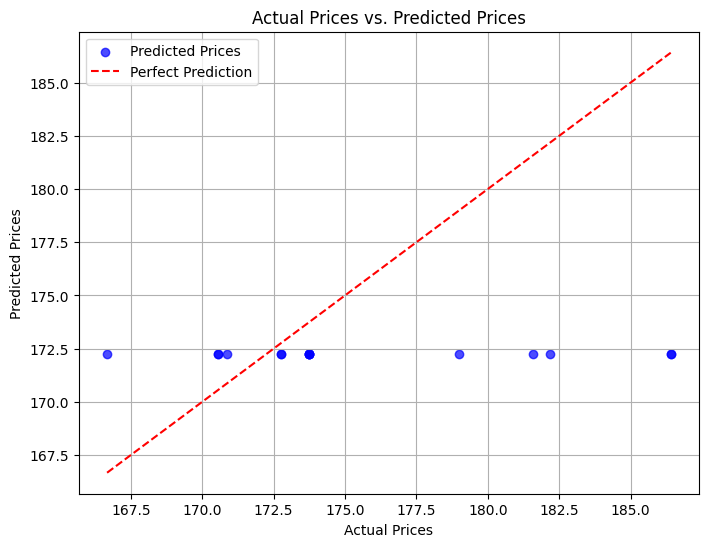

In [444]:
eval(svr_adj_close, X1_test, Y1_test)
plot(svr_adj_close.predict(X1_test), Y1_test)

### Results- Opening Price

In [445]:
svr_open.predict(X2_test)

array([171.51742308, 171.51742308, 171.51742308, 171.51742308,
       171.51742308, 171.51742308, 171.51742308, 171.51742307,
       171.51742308, 171.51742308, 171.51742308, 171.51742308,
       171.51742307, 171.51742308, 171.51742307, 171.51742308])

Mean Absolute Error (MAE): 3.66
Mean Squared Error (MSE): 33.52
R-squared (R2): -0.23
Confidence: 33.52


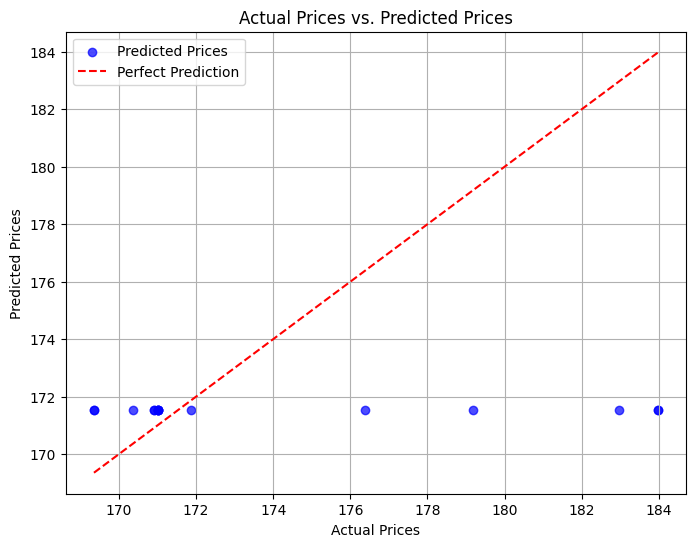

In [446]:
eval(svr_open, X2_test, Y2_test)
plot(svr_open.predict(X2_test), Y2_test)

In [447]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [448]:
import pickle

# save
with open('/content/drive/My Drive/q3_apple.pkl','wb') as f:
    pickle.dump(svr_open,f)

# load
# with open('q3_meta.pkl', 'rb') as f:
#     svr_open = pickle.load(f)